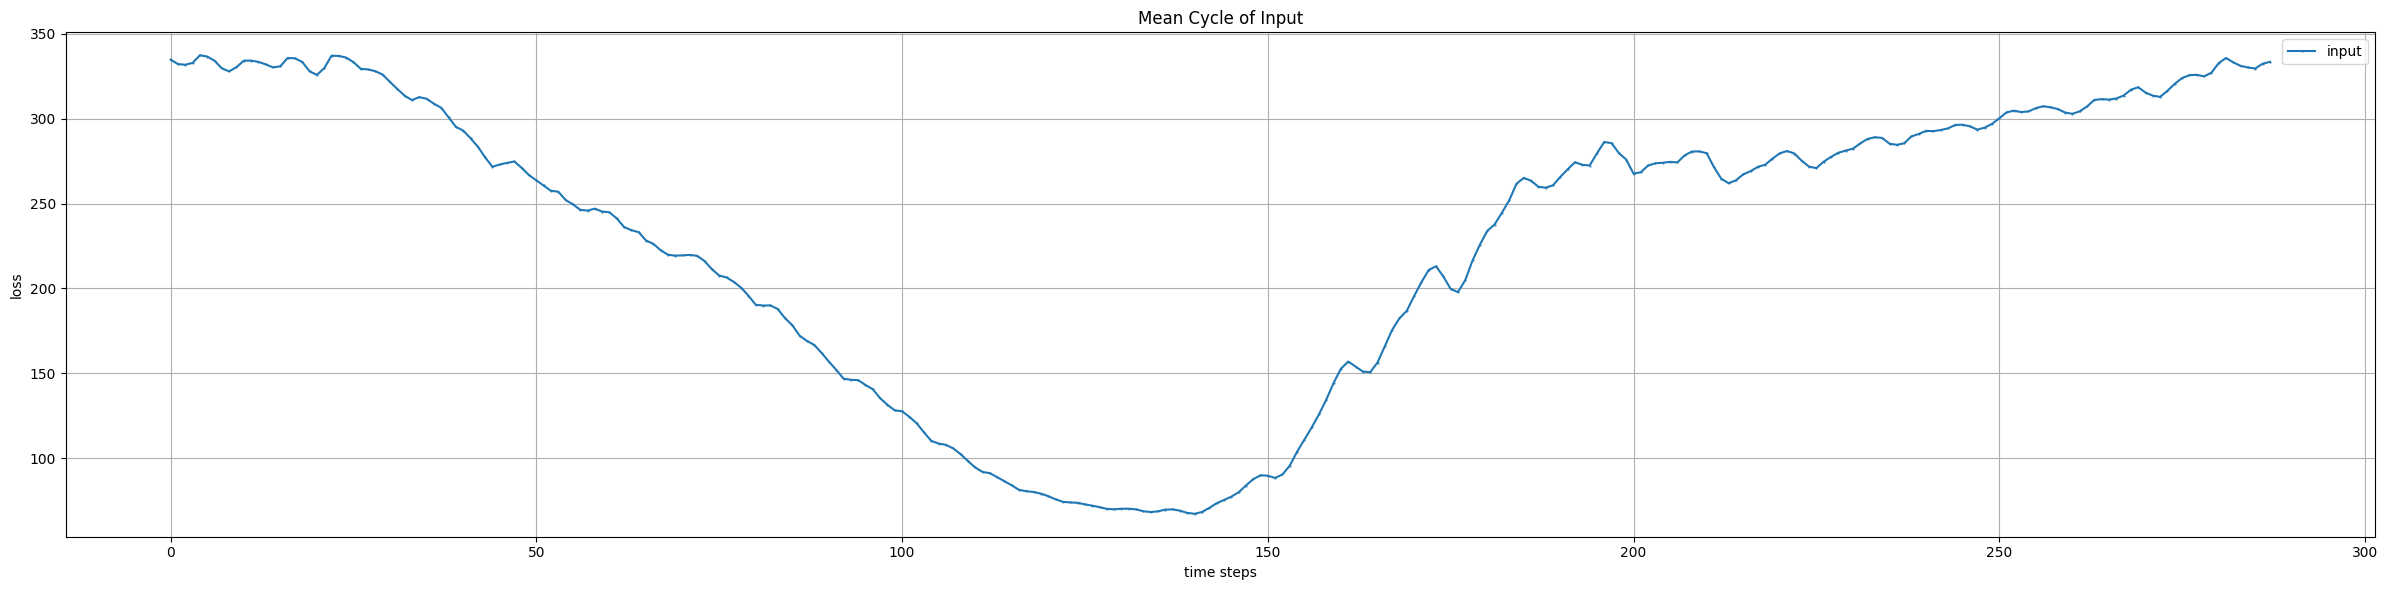

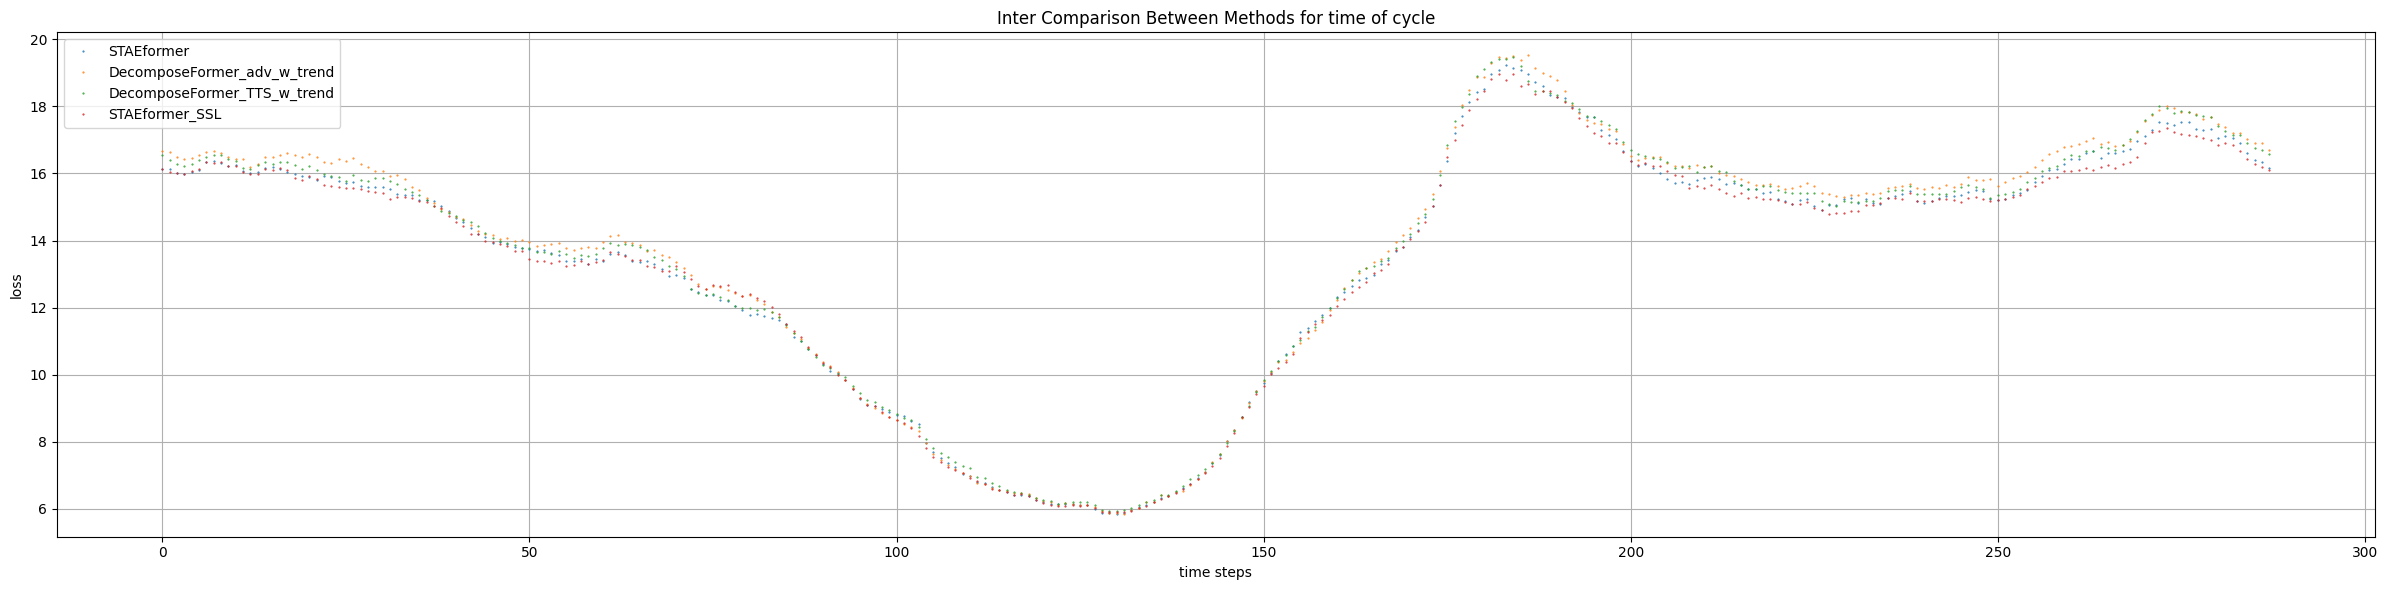

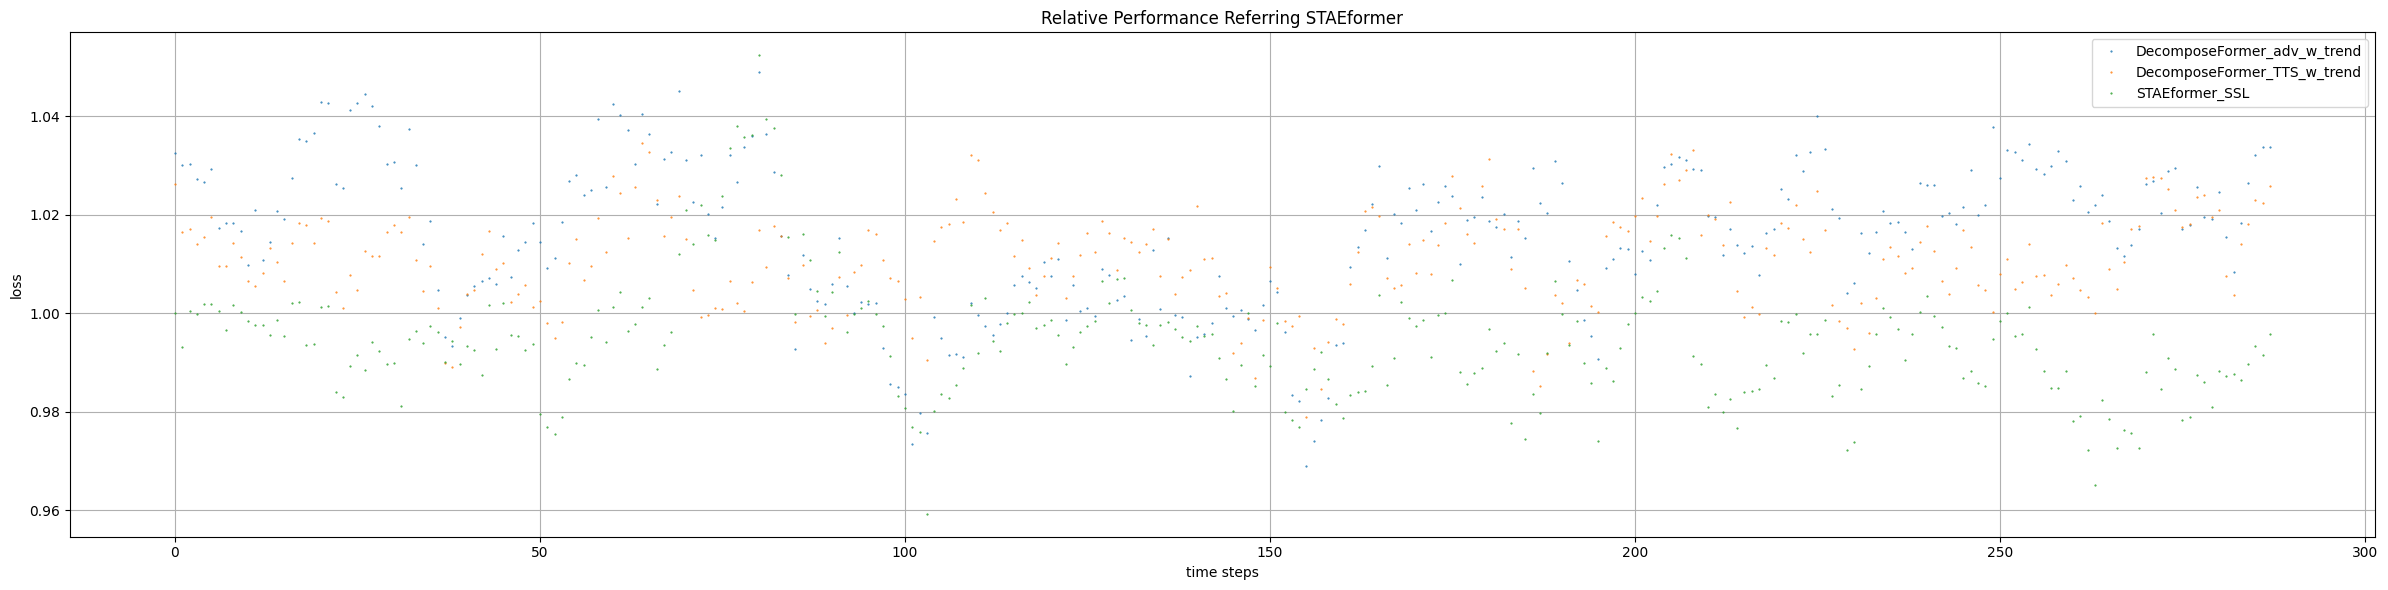

In [3]:
from basicts.utils.result import data_group_by_node_and_cycle
from typing import List
import numpy as np

from basicts.utils.visualize import plot_line


# 这一个cell的目的，是展示不同方法产生的预测结果，在一个循环周期内的分布
def visualize_mae_cycle_distri(method_result_files: List[str],
                               method_names: List[str],
                               cycle_timestamps: int,
                               referred_id: int):
    """
    :param method_result_files: 不同方法的预测结果文件
    :param method_names: 方法的名称
    :param cycle_timestamps: 一个循环包括多少时间步
    """
    mae_grouped_by_time_of_cycle = []
    inputs_cycle = None
    for file in method_result_files:
        # (N, cycle_timestamps, C) -> (cycle_timestamps)
        mae_grouped_by_node_and_time_of_cycle, input_grouped_by_node_and_time_of_cycle = data_group_by_node_and_cycle(file, cycle_timestamps)
        mae_grouped_by_node_and_time_of_cycle = mae_grouped_by_node_and_time_of_cycle[:, :, 0]
        input_grouped_by_node_and_time_of_cycle = input_grouped_by_node_and_time_of_cycle[:, :, 0]
        # (N, I, C)
        inputs_cycle = input_grouped_by_node_and_time_of_cycle
        mae_grouped_by_node_and_time_of_cycle = np.mean(mae_grouped_by_node_and_time_of_cycle, axis=0)
        mae_grouped_by_time_of_cycle.append(mae_grouped_by_node_and_time_of_cycle)
    inputs_cycle = np.mean(inputs_cycle, axis=0)
    plot_line(title="Mean Cycle of Input",
              x=[i for i in range(cycle_timestamps)], ys=[inputs_cycle],
              y_names=["input"], no_line=False)
    plot_line(title="Inter Comparison Between Methods for time of cycle",
              x=[i for i in range(cycle_timestamps)], ys=mae_grouped_by_time_of_cycle,
              y_names=method_names, no_line=True)
    relative_mae_grouped_by_time_of_cycle = []
    relative_names = []
    for idx, (mae, name) in enumerate(zip(mae_grouped_by_time_of_cycle, method_names)):
        if idx != referred_id:
            relative_mae_grouped_by_time_of_cycle.append(mae / mae_grouped_by_time_of_cycle[referred_id])
            relative_names.append(name)
    plot_line(title=f"Relative Performance Referring {method_names[referred_id]}",
            x=[i for i in range(cycle_timestamps)], ys=relative_mae_grouped_by_time_of_cycle,
            y_names=relative_names, no_line=True)

# 预测文件
prediction_files_pems08 = [
    "../checkpoints/STAEformer/PEMS08_100_12_12/70ceb2d1dd84b5dc181774f2d16a14c1/test_results.npz",
    "../checkpoints/DecomposeFormer_adv/PEMS08_100_12_12/165deb5b6eed720c6bd224ec75f4585a/test_results.npz",
    "../checkpoints/DecomposeFormer_TTS/PEMS08_100_12_12/d7fde011127742d7ea670292ecf8abd9/test_results.npz",
    "../checkpoints/STAEformer_SSL/PEMS08_100_12_12/ec5b5664aa4430d0d0c4f91673ef85c6/test_results.npz"
]
prediction_files_pems04 = [
    "../checkpoints/STAEformer/PEMS04_100_12_12/847a2ce08791eb89c3a325b199127003/test_results.npz",
    "../checkpoints/DecomposeFormer_adv/PEMS04_100_12_12/3b4d38f791b9a5449d5058ad504b18a0/test_results.npz",
    "../checkpoints/STAEformer_SSL/PEMS04_100_12_12/6cb833695c71cb7ce824ef6ebdd71aab/test_results.npz",
]
# 方法名称
method_names = [
    "STAEformer",
    "DecomposeFormer_adv_w_trend",
    "DecomposeFormer_TTS_w_trend",
    "STAEformer_SSL"
]
# 时间步
cts = 288
visualize_mae_cycle_distri(prediction_files_pems08, method_names, cts, 0)